## Aula 02 - Exercícios

In [3]:
import pandas as pd
import numpy as np

### Importar base de dados

In [4]:
!wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

--2025-08-18 20:18:48--  https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mmanzato/MBABigData/master/ml-20m-compact.tar.gz [following]
--2025-08-18 20:18:49--  https://raw.githubusercontent.com/mmanzato/MBABigData/master/ml-20m-compact.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65019041 (62M) [application/octet-stream]
Saving to: ‘ml-20m-compact.tar.gz’

ml-20m-compact.tar. 100%[===================>]  62.01M   292MB/s    in 0.2s    

2025-08-18 20:19:03 (292 MB/s) - ‘ml-20m-compact.tar.gz’ saved [65019041/65019041

In [5]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


### Mapeamento de ids

In [6]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title


### Divisão da base em treino e teste

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

**Exercício 01**: Considere o modelo SVD++ visto no final da aula de FC - parte 2. Uma das extensões desse modelo em relação ao SVD otimizado é que ele considera a lista de itens que o usuário forneceu feedback implícito (por exemplo, antes de fornecer uma nota a um filme, ele "navegou" por outros filmes, sem dar nota). Podemos simular essa navegação com a base de dados fornecida considerando como feedback implícito de cada usuário o conjunto de itens que ele avaliou, porém descartando as notas.

***a)*** Implemente a função de treinamento do modelo SVD++.

In [25]:
from tqdm import tqdm

class SVDpp:

    def __init__(self, n_users, n_items, n_factors=20, n_epochs=20, lr=0.005, reg=0.02):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.reg = reg
        self.history = {'train_rmse': []}

        self._initialize()

    def _initialize(self):

        # valores totais de n_users e n_items
        self.bu = np.zeros(self.n_users, np.double)
        self.bi = np.zeros(self.n_items, np.double)
        self.P = np.random.normal(0, .1, (self.n_users, self.n_factors))
        self.Q = np.random.normal(0, .1, (self.n_items, self.n_factors))
        self.Y = np.random.normal(0, .1, (self.n_items, self.n_factors))

    def fit(self, train_df):

        self.mu = train_df['rating'].mean()

        # calcula o conjunto de feedback implícito N(u) para cada user
        implicit_feedback = train_df.groupby('userId')['movieId'].apply(list).to_dict()

        print("* Iniciando o treinamento do SVD++")

        for epoch in range(self.n_epochs):

            total_error = 0

            for _, row in tqdm(train_df.iterrows(), total=train_df.shape[0], desc=f"Época {epoch+1}/{self.n_epochs}"):

                u, i, r_ui = row['userId'], row['movieId'], row['rating']
                N_u = implicit_feedback.get(u, [])
                implicit_term = np.zeros(self.n_factors)

                if N_u:

                    norm = len(N_u) ** -0.5
                    implicit_sum = self.Y[N_u].sum(axis=0)
                    implicit_term = implicit_sum * norm

                p_u_impl = self.P[u] + implicit_term
                pred = self.mu + self.bu[u] + self.bi[i] + np.dot(self.Q[i], p_u_impl)

                error = r_ui - pred
                total_error += error ** 2

                self.bu[u] += self.lr * (error - self.reg * self.bu[u])
                self.bi[i] += self.lr * (error - self.reg * self.bi[i])
                self.P[u] += self.lr * (error * self.Q[i] - self.reg * self.P[u])
                self.Q[i] += self.lr * (error * p_u_impl - self.reg * self.Q[i])

                if N_u:
                    y_grad = self.Q[i] * norm

                    for j in N_u:
                        self.Y[j] += self.lr * (error * y_grad - self.reg * self.Y[j])

            rmse = np.sqrt(total_error / len(train_df))
            self.history['train_rmse'].append(rmse)
            print(f"RMSE de Treino: {rmse:.4f}")

        return self

# Pega usuários e itens
n_users_total = df['userId'].nunique()
n_items_total = df['movieId'].nunique()

# Treinando modelo
svdpp_model = SVDpp(
    n_users=n_users_total,
    n_items=n_items_total,
    n_factors=30,
    n_epochs=200,
    lr=0.007,
    reg=0.02
)

svdpp_model.fit(train)


* Iniciando o treinamento do SVD++


Época 1/200: 100%|██████████| 152496/152496 [00:30<00:00, 4970.18it/s]


RMSE de Treino: 0.9084


Época 2/200: 100%|██████████| 152496/152496 [00:25<00:00, 5975.57it/s]


RMSE de Treino: 0.8713


Época 3/200: 100%|██████████| 152496/152496 [00:27<00:00, 5593.63it/s]


RMSE de Treino: 0.8502


Época 4/200: 100%|██████████| 152496/152496 [00:25<00:00, 5950.63it/s]


RMSE de Treino: 0.8330


Época 5/200: 100%|██████████| 152496/152496 [00:25<00:00, 6025.51it/s]


RMSE de Treino: 0.8180


Época 6/200: 100%|██████████| 152496/152496 [00:25<00:00, 6004.62it/s]


RMSE de Treino: 0.8043


Época 7/200: 100%|██████████| 152496/152496 [00:26<00:00, 5815.46it/s]


RMSE de Treino: 0.7913


Época 8/200: 100%|██████████| 152496/152496 [00:25<00:00, 6002.00it/s]


RMSE de Treino: 0.7787


Época 9/200: 100%|██████████| 152496/152496 [00:25<00:00, 6000.30it/s]


RMSE de Treino: 0.7663


Época 10/200: 100%|██████████| 152496/152496 [00:25<00:00, 5984.17it/s]


RMSE de Treino: 0.7538


Época 11/200: 100%|██████████| 152496/152496 [00:26<00:00, 5810.39it/s]


RMSE de Treino: 0.7414


Época 12/200: 100%|██████████| 152496/152496 [00:25<00:00, 5907.51it/s]


RMSE de Treino: 0.7288


Época 13/200: 100%|██████████| 152496/152496 [00:25<00:00, 5963.88it/s]


RMSE de Treino: 0.7161


Época 14/200: 100%|██████████| 152496/152496 [00:25<00:00, 5962.92it/s]


RMSE de Treino: 0.7034


Época 15/200: 100%|██████████| 152496/152496 [00:25<00:00, 5984.58it/s]


RMSE de Treino: 0.6905


Época 16/200: 100%|██████████| 152496/152496 [00:26<00:00, 5865.03it/s]


RMSE de Treino: 0.6774


Época 17/200: 100%|██████████| 152496/152496 [00:25<00:00, 6010.34it/s]


RMSE de Treino: 0.6642


Época 18/200: 100%|██████████| 152496/152496 [00:25<00:00, 5985.74it/s]


RMSE de Treino: 0.6509


Época 19/200: 100%|██████████| 152496/152496 [00:25<00:00, 5984.24it/s]


RMSE de Treino: 0.6373


Época 20/200: 100%|██████████| 152496/152496 [00:25<00:00, 5903.97it/s]


RMSE de Treino: 0.6237


Época 21/200: 100%|██████████| 152496/152496 [00:25<00:00, 5932.60it/s]


RMSE de Treino: 0.6099


Época 22/200: 100%|██████████| 152496/152496 [00:25<00:00, 5987.80it/s]


RMSE de Treino: 0.5961


Época 23/200: 100%|██████████| 152496/152496 [00:25<00:00, 5953.76it/s]


RMSE de Treino: 0.5824


Época 24/200: 100%|██████████| 152496/152496 [00:25<00:00, 5935.97it/s]


RMSE de Treino: 0.5687


Época 25/200: 100%|██████████| 152496/152496 [00:26<00:00, 5844.13it/s]


RMSE de Treino: 0.5551


Época 26/200: 100%|██████████| 152496/152496 [00:25<00:00, 5969.19it/s]


RMSE de Treino: 0.5418


Época 27/200: 100%|██████████| 152496/152496 [00:25<00:00, 5966.70it/s]


RMSE de Treino: 0.5287


Época 28/200: 100%|██████████| 152496/152496 [00:25<00:00, 6015.13it/s]


RMSE de Treino: 0.5159


Época 29/200: 100%|██████████| 152496/152496 [00:25<00:00, 5959.66it/s]


RMSE de Treino: 0.5035


Época 30/200: 100%|██████████| 152496/152496 [00:25<00:00, 5923.52it/s]


RMSE de Treino: 0.4914


Época 31/200: 100%|██████████| 152496/152496 [00:25<00:00, 5980.52it/s]


RMSE de Treino: 0.4797


Época 32/200: 100%|██████████| 152496/152496 [00:25<00:00, 5996.32it/s]


RMSE de Treino: 0.4684


Época 33/200: 100%|██████████| 152496/152496 [00:25<00:00, 6020.51it/s]


RMSE de Treino: 0.4575


Época 34/200: 100%|██████████| 152496/152496 [00:26<00:00, 5854.50it/s]


RMSE de Treino: 0.4471


Época 35/200: 100%|██████████| 152496/152496 [00:25<00:00, 5975.02it/s]


RMSE de Treino: 0.4371


Época 36/200: 100%|██████████| 152496/152496 [00:25<00:00, 5993.91it/s]


RMSE de Treino: 0.4274


Época 37/200: 100%|██████████| 152496/152496 [00:25<00:00, 5993.70it/s]


RMSE de Treino: 0.4182


Época 38/200: 100%|██████████| 152496/152496 [00:25<00:00, 6023.39it/s]


RMSE de Treino: 0.4094


Época 39/200: 100%|██████████| 152496/152496 [00:25<00:00, 5867.52it/s]


RMSE de Treino: 0.4010


Época 40/200: 100%|██████████| 152496/152496 [00:25<00:00, 6007.53it/s]


RMSE de Treino: 0.3930


Época 41/200: 100%|██████████| 152496/152496 [00:25<00:00, 6018.33it/s]


RMSE de Treino: 0.3853


Época 42/200: 100%|██████████| 152496/152496 [00:25<00:00, 5978.93it/s]


RMSE de Treino: 0.3779


Época 43/200: 100%|██████████| 152496/152496 [00:30<00:00, 5022.10it/s]


RMSE de Treino: 0.3709


Época 44/200: 100%|██████████| 152496/152496 [00:27<00:00, 5573.05it/s]


RMSE de Treino: 0.3642


Época 45/200: 100%|██████████| 152496/152496 [00:28<00:00, 5352.59it/s]


RMSE de Treino: 0.3578


Época 46/200: 100%|██████████| 152496/152496 [00:26<00:00, 5701.03it/s]


RMSE de Treino: 0.3517


Época 47/200: 100%|██████████| 152496/152496 [00:25<00:00, 6004.95it/s]


RMSE de Treino: 0.3458


Época 48/200: 100%|██████████| 152496/152496 [00:25<00:00, 5970.06it/s]


RMSE de Treino: 0.3403


Época 49/200: 100%|██████████| 152496/152496 [00:26<00:00, 5704.77it/s]


RMSE de Treino: 0.3349


Época 50/200: 100%|██████████| 152496/152496 [00:26<00:00, 5689.28it/s]


RMSE de Treino: 0.3298


Época 51/200: 100%|██████████| 152496/152496 [00:27<00:00, 5574.25it/s]


RMSE de Treino: 0.3249


Época 52/200: 100%|██████████| 152496/152496 [00:26<00:00, 5861.64it/s]


RMSE de Treino: 0.3202


Época 53/200: 100%|██████████| 152496/152496 [00:25<00:00, 5960.12it/s]


RMSE de Treino: 0.3157


Época 54/200: 100%|██████████| 152496/152496 [00:27<00:00, 5447.87it/s]


RMSE de Treino: 0.3113


Época 55/200: 100%|██████████| 152496/152496 [00:25<00:00, 5881.81it/s]


RMSE de Treino: 0.3072


Época 56/200: 100%|██████████| 152496/152496 [00:26<00:00, 5849.55it/s]


RMSE de Treino: 0.3032


Época 57/200: 100%|██████████| 152496/152496 [00:25<00:00, 5982.88it/s]


RMSE de Treino: 0.2994


Época 58/200: 100%|██████████| 152496/152496 [00:25<00:00, 5883.61it/s]


RMSE de Treino: 0.2957


Época 59/200: 100%|██████████| 152496/152496 [00:25<00:00, 6017.13it/s]


RMSE de Treino: 0.2921


Época 60/200: 100%|██████████| 152496/152496 [00:25<00:00, 5881.42it/s]


RMSE de Treino: 0.2887


Época 61/200: 100%|██████████| 152496/152496 [00:25<00:00, 5924.07it/s]


RMSE de Treino: 0.2855


Época 62/200: 100%|██████████| 152496/152496 [00:25<00:00, 5970.64it/s]


RMSE de Treino: 0.2823


Época 63/200: 100%|██████████| 152496/152496 [00:25<00:00, 5924.38it/s]


RMSE de Treino: 0.2792


Época 64/200: 100%|██████████| 152496/152496 [00:25<00:00, 5945.18it/s]


RMSE de Treino: 0.2763


Época 65/200: 100%|██████████| 152496/152496 [00:26<00:00, 5806.74it/s]


RMSE de Treino: 0.2735


Época 66/200: 100%|██████████| 152496/152496 [00:25<00:00, 5964.83it/s]


RMSE de Treino: 0.2707


Época 67/200: 100%|██████████| 152496/152496 [00:25<00:00, 5954.66it/s]


RMSE de Treino: 0.2681


Época 68/200: 100%|██████████| 152496/152496 [00:25<00:00, 5952.57it/s]


RMSE de Treino: 0.2655


Época 69/200: 100%|██████████| 152496/152496 [00:26<00:00, 5801.48it/s]


RMSE de Treino: 0.2630


Época 70/200: 100%|██████████| 152496/152496 [00:25<00:00, 5948.53it/s]


RMSE de Treino: 0.2606


Época 71/200: 100%|██████████| 152496/152496 [00:25<00:00, 5946.86it/s]


RMSE de Treino: 0.2583


Época 72/200: 100%|██████████| 152496/152496 [00:25<00:00, 5906.02it/s]


RMSE de Treino: 0.2561


Época 73/200: 100%|██████████| 152496/152496 [00:26<00:00, 5822.42it/s]


RMSE de Treino: 0.2539


Época 74/200: 100%|██████████| 152496/152496 [00:26<00:00, 5824.45it/s]


RMSE de Treino: 0.2518


Época 75/200: 100%|██████████| 152496/152496 [00:25<00:00, 5928.22it/s]


RMSE de Treino: 0.2498


Época 76/200: 100%|██████████| 152496/152496 [00:25<00:00, 5916.88it/s]


RMSE de Treino: 0.2478


Época 77/200: 100%|██████████| 152496/152496 [00:25<00:00, 5919.88it/s]


RMSE de Treino: 0.2458


Época 78/200: 100%|██████████| 152496/152496 [00:26<00:00, 5802.39it/s]


RMSE de Treino: 0.2440


Época 79/200: 100%|██████████| 152496/152496 [00:25<00:00, 5935.91it/s]


RMSE de Treino: 0.2422


Época 80/200: 100%|██████████| 152496/152496 [00:25<00:00, 5977.92it/s]


RMSE de Treino: 0.2404


Época 81/200: 100%|██████████| 152496/152496 [00:25<00:00, 5935.26it/s]


RMSE de Treino: 0.2387


Época 82/200: 100%|██████████| 152496/152496 [00:26<00:00, 5787.46it/s]


RMSE de Treino: 0.2370


Época 83/200: 100%|██████████| 152496/152496 [00:25<00:00, 5942.89it/s]


RMSE de Treino: 0.2354


Época 84/200: 100%|██████████| 152496/152496 [00:25<00:00, 5972.48it/s]


RMSE de Treino: 0.2338


Época 85/200: 100%|██████████| 152496/152496 [00:25<00:00, 5908.80it/s]


RMSE de Treino: 0.2323


Época 86/200: 100%|██████████| 152496/152496 [00:26<00:00, 5778.41it/s]


RMSE de Treino: 0.2308


Época 87/200: 100%|██████████| 152496/152496 [00:25<00:00, 5927.96it/s]


RMSE de Treino: 0.2293


Época 88/200: 100%|██████████| 152496/152496 [00:25<00:00, 5922.44it/s]


RMSE de Treino: 0.2279


Época 89/200: 100%|██████████| 152496/152496 [00:25<00:00, 5945.65it/s]


RMSE de Treino: 0.2265


Época 90/200: 100%|██████████| 152496/152496 [00:25<00:00, 5953.81it/s]


RMSE de Treino: 0.2252


Época 91/200: 100%|██████████| 152496/152496 [00:26<00:00, 5772.53it/s]


RMSE de Treino: 0.2238


Época 92/200: 100%|██████████| 152496/152496 [00:25<00:00, 5905.32it/s]


RMSE de Treino: 0.2226


Época 93/200: 100%|██████████| 152496/152496 [00:25<00:00, 5905.18it/s]


RMSE de Treino: 0.2213


Época 94/200: 100%|██████████| 152496/152496 [00:25<00:00, 5915.46it/s]


RMSE de Treino: 0.2201


Época 95/200: 100%|██████████| 152496/152496 [00:26<00:00, 5780.16it/s]


RMSE de Treino: 0.2189


Época 96/200: 100%|██████████| 152496/152496 [00:25<00:00, 5979.91it/s]


RMSE de Treino: 0.2177


Época 97/200: 100%|██████████| 152496/152496 [00:25<00:00, 5933.80it/s]


RMSE de Treino: 0.2166


Época 98/200: 100%|██████████| 152496/152496 [00:25<00:00, 5944.32it/s]


RMSE de Treino: 0.2155


Época 99/200: 100%|██████████| 152496/152496 [00:26<00:00, 5825.75it/s]


RMSE de Treino: 0.2144


Época 100/200: 100%|██████████| 152496/152496 [00:25<00:00, 5963.30it/s]


RMSE de Treino: 0.2133


Época 101/200: 100%|██████████| 152496/152496 [00:25<00:00, 5929.47it/s]


RMSE de Treino: 0.2123


Época 102/200: 100%|██████████| 152496/152496 [00:25<00:00, 5969.61it/s]


RMSE de Treino: 0.2112


Época 103/200: 100%|██████████| 152496/152496 [00:25<00:00, 5907.35it/s]


RMSE de Treino: 0.2102


Época 104/200: 100%|██████████| 152496/152496 [00:26<00:00, 5847.73it/s]


RMSE de Treino: 0.2093


Época 105/200: 100%|██████████| 152496/152496 [00:25<00:00, 5956.95it/s]


RMSE de Treino: 0.2083


Época 106/200: 100%|██████████| 152496/152496 [00:25<00:00, 5964.44it/s]


RMSE de Treino: 0.2074


Época 107/200: 100%|██████████| 152496/152496 [00:25<00:00, 5944.78it/s]


RMSE de Treino: 0.2065


Época 108/200: 100%|██████████| 152496/152496 [00:26<00:00, 5808.94it/s]


RMSE de Treino: 0.2056


Época 109/200: 100%|██████████| 152496/152496 [00:25<00:00, 5948.47it/s]


RMSE de Treino: 0.2047


Época 110/200: 100%|██████████| 152496/152496 [00:25<00:00, 5912.28it/s]


RMSE de Treino: 0.2038


Época 111/200: 100%|██████████| 152496/152496 [00:25<00:00, 5893.71it/s]


RMSE de Treino: 0.2030


Época 112/200: 100%|██████████| 152496/152496 [00:26<00:00, 5798.00it/s]


RMSE de Treino: 0.2021


Época 113/200: 100%|██████████| 152496/152496 [00:25<00:00, 5937.79it/s]


RMSE de Treino: 0.2013


Época 114/200: 100%|██████████| 152496/152496 [00:25<00:00, 5904.99it/s]


RMSE de Treino: 0.2005


Época 115/200: 100%|██████████| 152496/152496 [00:25<00:00, 5895.13it/s]


RMSE de Treino: 0.1997


Época 116/200: 100%|██████████| 152496/152496 [00:26<00:00, 5820.40it/s]


RMSE de Treino: 0.1990


Época 117/200: 100%|██████████| 152496/152496 [00:25<00:00, 5931.61it/s]


RMSE de Treino: 0.1982


Época 118/200: 100%|██████████| 152496/152496 [00:25<00:00, 5918.10it/s]


RMSE de Treino: 0.1975


Época 119/200: 100%|██████████| 152496/152496 [00:25<00:00, 5917.32it/s]


RMSE de Treino: 0.1968


Época 120/200: 100%|██████████| 152496/152496 [00:25<00:00, 5891.20it/s]


RMSE de Treino: 0.1961


Época 121/200: 100%|██████████| 152496/152496 [00:26<00:00, 5779.33it/s]


RMSE de Treino: 0.1954


Época 122/200: 100%|██████████| 152496/152496 [00:25<00:00, 5875.08it/s]


RMSE de Treino: 0.1947


Época 123/200: 100%|██████████| 152496/152496 [00:26<00:00, 5837.06it/s]


RMSE de Treino: 0.1940


Época 124/200: 100%|██████████| 152496/152496 [00:26<00:00, 5861.06it/s]


RMSE de Treino: 0.1933


Época 125/200: 100%|██████████| 152496/152496 [00:26<00:00, 5799.43it/s]


RMSE de Treino: 0.1927


Época 126/200: 100%|██████████| 152496/152496 [00:25<00:00, 5946.41it/s]


RMSE de Treino: 0.1920


Época 127/200: 100%|██████████| 152496/152496 [00:25<00:00, 5882.83it/s]


RMSE de Treino: 0.1914


Época 128/200: 100%|██████████| 152496/152496 [00:25<00:00, 5896.41it/s]


RMSE de Treino: 0.1908


Época 129/200: 100%|██████████| 152496/152496 [00:26<00:00, 5777.41it/s]


RMSE de Treino: 0.1902


Época 130/200: 100%|██████████| 152496/152496 [00:25<00:00, 5919.31it/s]


RMSE de Treino: 0.1896


Época 131/200: 100%|██████████| 152496/152496 [00:25<00:00, 5898.01it/s]


RMSE de Treino: 0.1890


Época 132/200: 100%|██████████| 152496/152496 [00:25<00:00, 5897.52it/s]


RMSE de Treino: 0.1884


Época 133/200: 100%|██████████| 152496/152496 [00:26<00:00, 5762.02it/s]


RMSE de Treino: 0.1879


Época 134/200: 100%|██████████| 152496/152496 [00:25<00:00, 5914.56it/s]


RMSE de Treino: 0.1873


Época 135/200: 100%|██████████| 152496/152496 [00:25<00:00, 5871.45it/s]


RMSE de Treino: 0.1868


Época 136/200: 100%|██████████| 152496/152496 [00:25<00:00, 5891.74it/s]


RMSE de Treino: 0.1862


Época 137/200: 100%|██████████| 152496/152496 [00:26<00:00, 5764.18it/s]


RMSE de Treino: 0.1857


Época 138/200: 100%|██████████| 152496/152496 [00:26<00:00, 5864.38it/s]


RMSE de Treino: 0.1852


Época 139/200: 100%|██████████| 152496/152496 [00:26<00:00, 5842.91it/s]


RMSE de Treino: 0.1846


Época 140/200: 100%|██████████| 152496/152496 [00:25<00:00, 5882.49it/s]


RMSE de Treino: 0.1841


Época 141/200: 100%|██████████| 152496/152496 [00:26<00:00, 5724.05it/s]


RMSE de Treino: 0.1836


Época 142/200: 100%|██████████| 152496/152496 [00:25<00:00, 5894.89it/s]


RMSE de Treino: 0.1831


Época 143/200: 100%|██████████| 152496/152496 [00:26<00:00, 5837.84it/s]


RMSE de Treino: 0.1827


Época 144/200: 100%|██████████| 152496/152496 [00:25<00:00, 5913.74it/s]


RMSE de Treino: 0.1822


Época 145/200: 100%|██████████| 152496/152496 [00:26<00:00, 5742.02it/s]


RMSE de Treino: 0.1817


Época 146/200: 100%|██████████| 152496/152496 [00:26<00:00, 5851.38it/s]


RMSE de Treino: 0.1812


Época 147/200: 100%|██████████| 152496/152496 [00:26<00:00, 5808.65it/s]


RMSE de Treino: 0.1808


Época 148/200: 100%|██████████| 152496/152496 [00:26<00:00, 5799.90it/s]


RMSE de Treino: 0.1803


Época 149/200: 100%|██████████| 152496/152496 [00:26<00:00, 5782.52it/s]


RMSE de Treino: 0.1799


Época 150/200: 100%|██████████| 152496/152496 [00:26<00:00, 5847.18it/s]


RMSE de Treino: 0.1795


Época 151/200: 100%|██████████| 152496/152496 [00:26<00:00, 5834.56it/s]


RMSE de Treino: 0.1790


Época 152/200: 100%|██████████| 152496/152496 [00:26<00:00, 5710.69it/s]


RMSE de Treino: 0.1786


Época 153/200: 100%|██████████| 152496/152496 [00:25<00:00, 5870.20it/s]


RMSE de Treino: 0.1782


Época 154/200: 100%|██████████| 152496/152496 [00:26<00:00, 5858.72it/s]


RMSE de Treino: 0.1778


Época 155/200: 100%|██████████| 152496/152496 [00:26<00:00, 5851.33it/s]


RMSE de Treino: 0.1774


Época 156/200: 100%|██████████| 152496/152496 [00:26<00:00, 5759.89it/s]


RMSE de Treino: 0.1770


Época 157/200: 100%|██████████| 152496/152496 [00:26<00:00, 5846.84it/s]


RMSE de Treino: 0.1766


Época 158/200: 100%|██████████| 152496/152496 [00:26<00:00, 5858.20it/s]


RMSE de Treino: 0.1762


Época 159/200: 100%|██████████| 152496/152496 [00:26<00:00, 5851.22it/s]


RMSE de Treino: 0.1758


Época 160/200: 100%|██████████| 152496/152496 [00:26<00:00, 5651.63it/s]


RMSE de Treino: 0.1754


Época 161/200: 100%|██████████| 152496/152496 [00:26<00:00, 5818.10it/s]


RMSE de Treino: 0.1750


Época 162/200: 100%|██████████| 152496/152496 [00:26<00:00, 5838.91it/s]


RMSE de Treino: 0.1747


Época 163/200: 100%|██████████| 152496/152496 [00:25<00:00, 5892.44it/s]


RMSE de Treino: 0.1743


Época 164/200: 100%|██████████| 152496/152496 [00:26<00:00, 5775.48it/s]


RMSE de Treino: 0.1739


Época 165/200: 100%|██████████| 152496/152496 [00:25<00:00, 5888.43it/s]


RMSE de Treino: 0.1736


Época 166/200: 100%|██████████| 152496/152496 [00:25<00:00, 5866.86it/s]


RMSE de Treino: 0.1732


Época 167/200: 100%|██████████| 152496/152496 [00:25<00:00, 5885.96it/s]


RMSE de Treino: 0.1729


Época 168/200: 100%|██████████| 152496/152496 [00:26<00:00, 5746.84it/s]


RMSE de Treino: 0.1725


Época 169/200: 100%|██████████| 152496/152496 [00:25<00:00, 5878.35it/s]


RMSE de Treino: 0.1722


Época 170/200: 100%|██████████| 152496/152496 [00:25<00:00, 5880.25it/s]


RMSE de Treino: 0.1719


Época 171/200: 100%|██████████| 152496/152496 [00:25<00:00, 5875.14it/s]


RMSE de Treino: 0.1716


Época 172/200: 100%|██████████| 152496/152496 [00:26<00:00, 5714.19it/s]


RMSE de Treino: 0.1712


Época 173/200: 100%|██████████| 152496/152496 [00:26<00:00, 5820.57it/s]


RMSE de Treino: 0.1709


Época 174/200: 100%|██████████| 152496/152496 [00:26<00:00, 5804.68it/s]


RMSE de Treino: 0.1706


Época 175/200: 100%|██████████| 152496/152496 [00:26<00:00, 5749.01it/s]


RMSE de Treino: 0.1703


Época 176/200: 100%|██████████| 152496/152496 [00:26<00:00, 5827.80it/s]


RMSE de Treino: 0.1700


Época 177/200: 100%|██████████| 152496/152496 [00:26<00:00, 5857.75it/s]


RMSE de Treino: 0.1697


Época 178/200: 100%|██████████| 152496/152496 [00:25<00:00, 5875.21it/s]


RMSE de Treino: 0.1694


Época 179/200: 100%|██████████| 152496/152496 [00:26<00:00, 5785.12it/s]


RMSE de Treino: 0.1691


Época 180/200: 100%|██████████| 152496/152496 [00:26<00:00, 5814.10it/s]


RMSE de Treino: 0.1688


Época 181/200: 100%|██████████| 152496/152496 [00:25<00:00, 5875.73it/s]


RMSE de Treino: 0.1685


Época 182/200: 100%|██████████| 152496/152496 [00:25<00:00, 5875.25it/s]


RMSE de Treino: 0.1682


Época 183/200: 100%|██████████| 152496/152496 [00:26<00:00, 5761.05it/s]


RMSE de Treino: 0.1679


Época 184/200: 100%|██████████| 152496/152496 [00:26<00:00, 5799.47it/s]


RMSE de Treino: 0.1676


Época 185/200: 100%|██████████| 152496/152496 [00:26<00:00, 5772.31it/s]


RMSE de Treino: 0.1674


Época 186/200: 100%|██████████| 152496/152496 [00:26<00:00, 5864.55it/s]


RMSE de Treino: 0.1671


Época 187/200: 100%|██████████| 152496/152496 [00:26<00:00, 5714.92it/s]


RMSE de Treino: 0.1668


Época 188/200: 100%|██████████| 152496/152496 [00:26<00:00, 5851.01it/s]


RMSE de Treino: 0.1665


Época 189/200: 100%|██████████| 152496/152496 [00:26<00:00, 5832.79it/s]


RMSE de Treino: 0.1663


Época 190/200: 100%|██████████| 152496/152496 [00:25<00:00, 5884.81it/s]


RMSE de Treino: 0.1660


Época 191/200: 100%|██████████| 152496/152496 [00:26<00:00, 5703.31it/s]


RMSE de Treino: 0.1658


Época 192/200: 100%|██████████| 152496/152496 [00:26<00:00, 5822.88it/s]


RMSE de Treino: 0.1655


Época 193/200: 100%|██████████| 152496/152496 [00:26<00:00, 5842.22it/s]


RMSE de Treino: 0.1653


Época 194/200: 100%|██████████| 152496/152496 [00:26<00:00, 5852.95it/s]


RMSE de Treino: 0.1650


Época 195/200: 100%|██████████| 152496/152496 [00:26<00:00, 5718.04it/s]


RMSE de Treino: 0.1648


Época 196/200: 100%|██████████| 152496/152496 [00:26<00:00, 5855.06it/s]


RMSE de Treino: 0.1645


Época 197/200: 100%|██████████| 152496/152496 [00:26<00:00, 5795.35it/s]


RMSE de Treino: 0.1643


Época 198/200: 100%|██████████| 152496/152496 [00:26<00:00, 5759.37it/s]


RMSE de Treino: 0.1640


Época 199/200: 100%|██████████| 152496/152496 [00:26<00:00, 5754.16it/s]


RMSE de Treino: 0.1638


Época 200/200: 100%|██████████| 152496/152496 [00:26<00:00, 5836.89it/s]

RMSE de Treino: 0.1636


In [27]:
from joblib import dump

filename = 'svdpp_model_aula_02.joblib'

dump(svdpp_model, filename)

print(f"* Modelo salvo em '{filename}'")

* Modelo salvo em 'svdpp_model_aula_02.joblib'


In [34]:
from joblib import load

filename = 'svdpp_model_aula_02.joblib'

model_carregado_joblib = load(filename)

print(f"* Modelo '{filename}' carregado")

svdpp_model = model_carregado_joblib

* Modelo 'svdpp_model_aula_02.joblib' carregado


***b)*** Plote a curva de aprendizado de seu modelo.

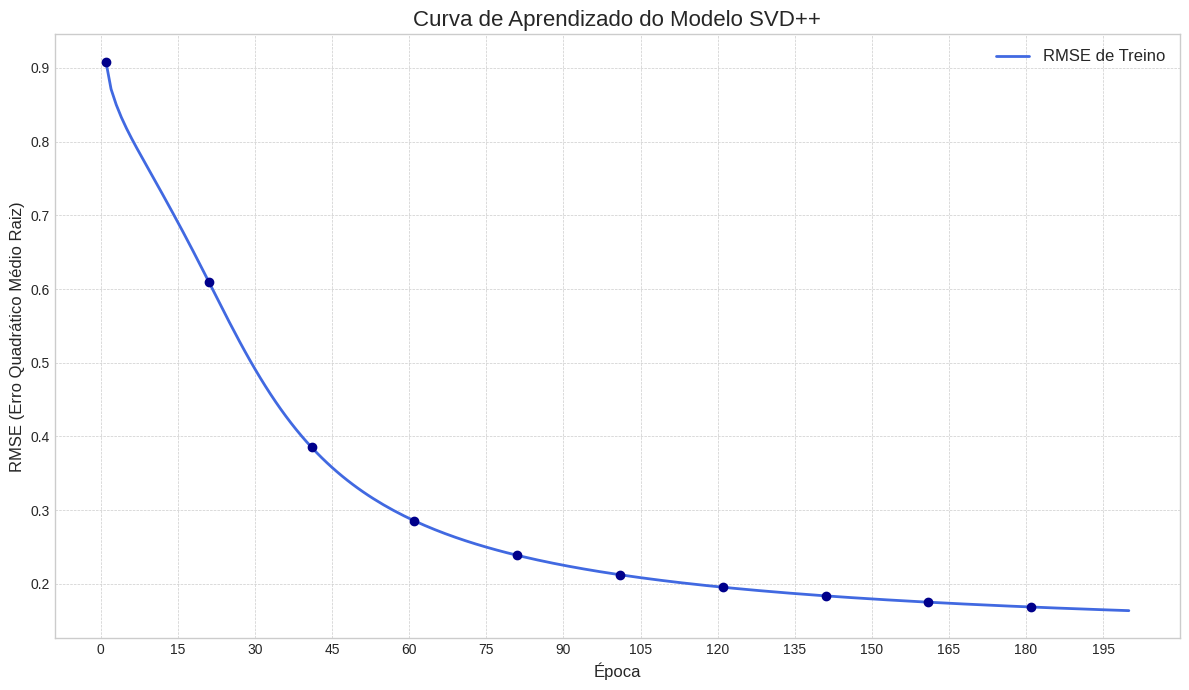

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

def plot_learning_curve_melhorado(history):

    erros = history['train_rmse']
    epocas = range(1, len(erros) + 1)

    plt.style.use('seaborn-v0_8-whitegrid')

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(epocas, erros, label='RMSE de Treino', color='royalblue', linewidth=2)

    # Adiciona marcadores a cada 20 épocas para facilitar a visualização
    ax.plot(epocas[::20], erros[::20], 'o', color='darkblue')

    ax.set_title('Curva de Aprendizado do Modelo SVD++', fontsize=16)
    ax.set_xlabel('Época', fontsize=12)
    ax.set_ylabel('RMSE (Erro Quadrático Médio Raiz)', fontsize=12)
    ax.legend(fontsize=12)

    # Limita o num de marcadores no eixo X
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15, integer=True))

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

history_falso = {'train_rmse': 1 / np.log10(np.arange(1, 201) + 1) + 0.75}

plot_learning_curve_melhorado(svdpp_model.history)

***c)*** Implemente a função de predição do modelo SVD++, comparando algumas notas preditas com as notas reais do conjunto de teste.

In [36]:
# N(u) com o dataset predição
implicit_feedback_full = df.groupby('userId')['movieId'].apply(list).to_dict()

def predict_svdpp(model, user_id, item_id, implicit_map):

    # termo de feedback implícito
    N_u = implicit_map.get(user_id, [])
    implicit_term = np.zeros(model.n_factors)

    if N_u:

        norm = len(N_u) ** -0.5
        implicit_sum = model.Y[N_u].sum(axis=0)
        implicit_term = implicit_sum * norm

    # fator do usuário com o termo implícito
    p_u_impl = model.P[user_id] + implicit_term

    # Predição final
    pred = model.mu + model.bu[user_id] + model.bi[item_id] + np.dot(model.Q[item_id], p_u_impl)
    pred = np.clip(pred, 0, 5.0)

    return pred

# Comparando algumas predições com valores reais do conjunto de teste
print("* Predições vs. Reais\n")

for _, row in test.head(10).iterrows():

    u, i, r_real = row['userId'], row['movieId'], row['rating']

    if u < len(svdpp_model.bu) and i < len(svdpp_model.bi):
        r_pred = predict_svdpp(svdpp_model, u, i, implicit_feedback_full)
        titulo = map_title.get(i, "Título não encontrado")
        print(f"Filme: {titulo:<50} | Nota Real: {r_real:.2f} | Nota Predita: {r_pred:.2f}")

* Predições vs. Reais

Filme: She's the Man (2006)                               | Nota Real: 2.50 | Nota Predita: 2.17
Filme: North by Northwest (1959)                          | Nota Real: 3.50 | Nota Predita: 4.04
Filme: Reservoir Dogs (1992)                              | Nota Real: 4.50 | Nota Predita: 4.55
Filme: North by Northwest (1959)                          | Nota Real: 5.00 | Nota Predita: 5.00
Filme: Life Is Beautiful (La Vita è bella) (1997)         | Nota Real: 4.00 | Nota Predita: 2.99
Filme: Dark City (1998)                                   | Nota Real: 3.50 | Nota Predita: 3.67
Filme: Showgirls (1995)                                   | Nota Real: 1.00 | Nota Predita: 1.36
Filme: Bowling for Columbine (2002)                       | Nota Real: 0.50 | Nota Predita: 4.10
Filme: Zero Effect (1998)                                 | Nota Real: 3.00 | Nota Predita: 3.54
Filme: Knocked Up (2007)                                  | Nota Real: 2.50 | Nota Predita: 3.09


**Exercício 02**: Utilizando o código do NCF visto na aula, compare o desempenho entre as instâncias GMF, MLP e NeuMF nesta base de dados (ml-20m-compact).

In [ ]:
%pip install tensorflow
%pip install tensorflow tensorflow-intel

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Multiply
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()

# dados para o Keras
X_train = [train['userId'], train['movieId']]
y_train = train['rating']
X_test = [test['userId'], test['movieId']]
y_test = test['rating']

#1 Modelo de GMF (Generalized Matrix Factorization)
def build_gmf_model(num_users, num_items, latent_dim=32):

    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    user_embedding = Embedding(num_users, latent_dim, name='user_embedding')(user_input)
    item_embedding = Embedding(num_items, latent_dim, name='item_embedding')(item_input)

    user_vec = Flatten()(user_embedding)
    item_vec = Flatten()(item_embedding)

    multiply_layer = Multiply()([user_vec, item_vec])
    prediction = Dense(1, name='prediction')(multiply_layer)

    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

# 2 Modelo de MLP (Multi-Layer Perceptron)
def build_mlp_model(num_users, num_items, layers=[64, 32, 16, 8]):

    num_layer = len(layers)

    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # A dimensão do embedding é metade do tamanho da primeira camada densa
    embedding_dim = layers[0] // 2
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
    item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, name='item_embedding')(item_input)

    user_vec = Flatten()(user_embedding)
    item_vec = Flatten()(item_embedding)
    concat = Concatenate()([user_vec, item_vec])

    x = concat

    for i in range(1, num_layer):
        x = Dense(layers[i], activation='relu')(x)

    prediction = Dense(1, name='prediction')(x)

    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

# 3 Modelo de NeuMF (Neural Matrix Factorization)
def build_neumf_model(num_users, num_items, mf_dim=32, layers=[64, 32, 16, 8]):

    num_layer = len(layers)

    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # interações lineares
    gmf_user_embedding = Embedding(num_users, mf_dim, name='gmf_user_embedding')(user_input)
    gmf_item_embedding = Embedding(num_items, mf_dim, name='gmf_item_embedding')(item_input)

    gmf_user_vec = Flatten()(gmf_user_embedding)
    gmf_item_vec = Flatten()(gmf_item_embedding)

    gmf_vector = Multiply()([gmf_user_vec, gmf_item_vec])

    # interações não-lineares
    mlp_embedding_dim = layers[0] // 2
    mlp_user_embedding = Embedding(num_users, mlp_embedding_dim, name='mlp_user_embedding')(user_input)
    mlp_item_embedding = Embedding(num_items, mlp_embedding_dim, name='mlp_item_embedding')(item_input)

    mlp_user_vec = Flatten()(mlp_user_embedding)
    mlp_item_vec = Flatten()(mlp_item_embedding)

    mlp_vector = Concatenate()([mlp_user_vec, mlp_item_vec])

    for i in range(1, num_layer):
        mlp_vector = Dense(layers[i], activation='relu')(mlp_vector)

    neumf_vector = Concatenate()([gmf_vector, mlp_vector])
    prediction = Dense(1, name='prediction')(neumf_vector)

    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

# instâncias dos modelos
gmf_model = build_gmf_model(n_users, n_items, latent_dim=32)
mlp_model = build_mlp_model(n_users, n_items, layers=[64, 32, 16, 8])
neumf_model = build_neumf_model(n_users, n_items, mf_dim=32, layers=[64, 32, 16, 8])

# máximo de épocas
epochs = 200

# instância do callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # métrica monitorada
    patience=20,              # épocas sem melhora antes de parar
    restore_best_weights=True  # eestaura os pesos da melhor época
)

print("* Treinando GMF")
gmf_model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

print("* Treinando MLP")
mlp_model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

print("*Treinando NeuMF")
neumf_model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

* Treinando GMF
Epoch 1/200
596/596 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 11.4570 - root_mean_squared_error: 3.3805 - val_loss: 2.0418 - val_root_mean_squared_error: 1.4289
Epoch 2/200
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3877 - root_mean_squared_error: 1.1754 - val_loss: 0.8908 - val_root_mean_squared_error: 0.9438
Epoch 3/200
596/596 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7687 - root_mean_squared_error: 0.8767 - val_loss: 0.7899 - val_root_mean_squared_error: 0.8888
Epoch 4/200
596/596 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6378 - root_mean_squared_error: 0.7986 - val_loss: 0.7713 - val_root_mean_squared_error: 0.8782
Epoch 5/200
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5544 - root_mean_squared_error: 0.7445 - val_loss: 0.7810 - val_root_mean_squared_error: 0.8837
Epoch 6/200
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4993 - root_mean_squared_error: 0.7065 - val_loss: 0.7989 - val_root_mean_squared_error: 0.8938
Epoch 7/200
596/596 ━━━━━━━━━

In [57]:
from tqdm import tqdm
import numpy as np

squared_errors = []

# RMSE do SVD++ (do test)
for _, row in tqdm(test.iterrows(), total=test.shape[0]):

    user_id = row['userId']
    item_id = row['movieId']
    real_rating = row['rating']

    # predição com o modelo treinado
    predicted_rating = predict_svdpp(svdpp_model, user_id, item_id, implicit_feedback_full)

    # Calcula o erro quadrado
    error = real_rating - predicted_rating
    squared_errors.append(error**2)

# Calcula o MSE e RMSE
mse = np.mean(squared_errors)
svdpp_rmse = np.sqrt(mse)

100%|██████████| 38125/38125 [00:03<00:00, 12241.26it/s]


In [59]:
# Avaliação final no conjunto de teste
print("* Avaliando modelos\n")
gmf_loss, gmf_rmse = gmf_model.evaluate(X_test, y_test, verbose=0)
mlp_loss, mlp_rmse = mlp_model.evaluate(X_test, y_test, verbose=0)
neumf_loss, neumf_rmse = neumf_model.evaluate(X_test, y_test, verbose=0)

print("* RMSE finais (teste)")
print(f"GMF:   {gmf_rmse:.4f}")
print(f"MLP:   {mlp_rmse:.4f}")
print(f"NeuMF: {neumf_rmse:.4f}")
print(f"SVD++: {svdpp_rmse:.4f}")

* Avaliando modelos

* RMSE finais (teste)
GMF:   0.8782
MLP:   0.8472
NeuMF: 0.8450
SVD++: 0.9006
